
--- TWO-BODY PROPAGATOR - J2 & ATMOSPHERIC DRAG PERTURBATIONS ---


Process finished --- 101.41698932647705


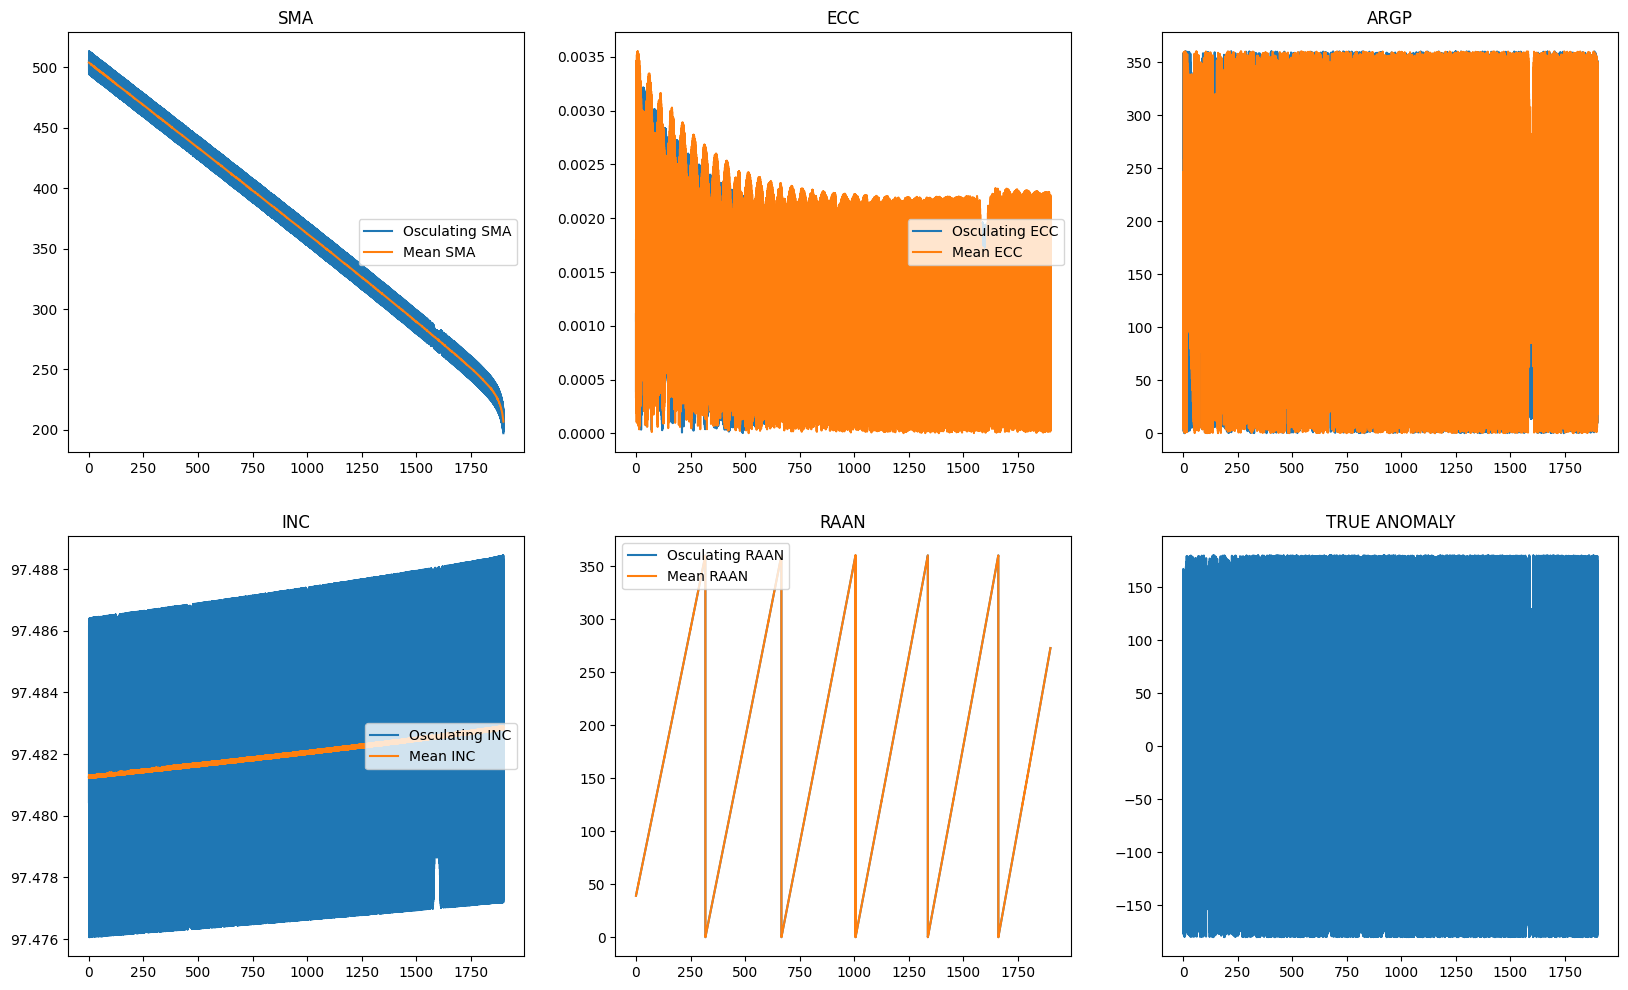

In [16]:
## ORBIT PROPAGATOR WITH J2 + ATMOSPHERIC DRAG PERTURBATIONS

from astropy import units as u
from astropy.time import Time, TimeDelta

from poliastro.bodies import Earth
from poliastro.constants import rho0_earth, H0_earth
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import CowellPropagator
from poliastro.twobody.sampling import EpochsArray
from poliastro.core.perturbations import J2_perturbation, atmospheric_drag_exponential
from poliastro.core.propagation import func_twobody 
from poliastro.util import Time
#from poliastro.plotting import OrbitPlotter2D

from numba import njit as jit

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import time

from mean_elements_prop import osc2mean


print('\n--- TWO-BODY PROPAGATOR - J2 & ATMOSPHERIC DRAG PERTURBATIONS ---\n')
# initial orbital elements
# RHW:
a    = 6865.501217 * u.km         #6865.501217
ecc  = 0.0016628   * u.one
inc  = 97.4864     * u.deg
raan = 39.164      * u.deg
argp = 325.3203    * u.deg
nu   = 126.202     * u.deg 

start_date = Time("2018-11-30 03:53:03.550", scale = "utc")   # epoch 2018 11-30

# Definition of the initial orbit (poliastro)
in_orbit = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu, start_date)


time_frame = 1900<<u.day
time_step  = 3600<<u.s

process_start_time = time.time()   # start time of python code


# Constants
R = Earth.R.to(u.km).value
k = Earth.k.to(u.km**3 / u.s**2).value
J2 = Earth.J2.value

rho0 = rho0_earth.to(u.kg/u.km**3).value
H0   = H0_earth.to(u.km).value

# GMAT correct RHW orbit decay was for: C_D = 2.2, A = 0.02 m^2, m = 2.205 kg
C_D = 2.2
A_over_m = ((0.01 * u.m**2) / (2.5 * u.kg)).to_value(u.km**2 / u.kg)   # km**2/kg
B = C_D * A_over_m   # ballistic coefficient at low drag mode



a_list     = []
ecc_list   = []
inc_list   = []
raan_list  = []
argp_list  = []
nu_list    = []
epoch_list = []

a_mean_list = []
ecc_mean_list = []
inc_mean_list = []
raan_mean_list = []
argp_mean_list = []
ma_mean_list = []

t = time_step
old_orbit = in_orbit

@jit
def a_d(t0, state, k, J2, R, C_D, A_over_m, H0, rho0):

        return J2_perturbation(
        t0, state, k, J2, R
        ) + atmospheric_drag_exponential(
            t0, state, k, R, C_D, A_over_m, H0, rho0
        )
        
def f(t0, state, k):
        
        du_kep = func_twobody(t0, state, k)
        ax, ay, az = a_d(
            t0, 
            state, 
            k=k, 
            J2 = J2, 
            R = R, 
            C_D = C_D, 
            A_over_m = A_over_m, 
            H0 = H0, 
            rho0 = rho0
            )
        du_ad = np.array([0, 0, 0, ax, ay, az])

        return du_kep + du_ad

elapsedsecs = []
while t <= time_frame:

    elapsedsecs.append(t.value)
    date = old_orbit.epoch.value

    new_orbit = old_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=f))


    a_list.append(new_orbit.a.value)
    ecc_list.append(new_orbit.ecc.value)
    inc_list.append(new_orbit.inc.to_value(u.deg))
    raan_list.append(new_orbit.raan.to_value(u.deg))
    argp_list.append(new_orbit.argp.to_value(u.deg))
    nu_list.append(new_orbit.nu.to_value(u.deg))
    epoch_list.append(new_orbit.epoch.value)

    mean_elements = osc2mean(
          new_orbit.a.value,
          new_orbit.ecc.value,
          new_orbit.inc.to_value(u.deg),
          new_orbit.raan.to_value(u.deg),
          new_orbit.argp.to_value(u.deg),
          new_orbit.nu.to_value(u.deg)
    )

    a_mean_list.append(mean_elements[0])
    ecc_mean_list.append(mean_elements[1])
    inc_mean_list.append(mean_elements[2])
    raan_mean_list.append(mean_elements[3])
    argp_mean_list.append(mean_elements[4])
    ma_mean_list.append(mean_elements[5])


    old_orbit = new_orbit
    t = t + time_step

elapsed_days = []
for sec in range(len(elapsedsecs)):
    elapsed_days.append(elapsedsecs[sec]/(60*60*24))

altitudes = []
mean_altitudes = []
for sma in range(len(a_list)):
    altitudes.append(a_list[sma] - Earth.R_mean.to_value(u.km))
    mean_altitudes.append(a_mean_list[sma] - Earth.R_mean.to_value(u.km))


print(f'\nProcess finished --- {time.time() - process_start_time}')

fig, ax = plt.subplots(2,3, figsize=(20,12))
ax[0,0].plot(elapsed_days, altitudes, label='Osculating SMA')
ax[0,0].plot(elapsed_days, mean_altitudes, label='Mean SMA')
ax[0,0].legend(loc = 'center right')
ax[0,0].set_title('SMA')

ax[0,1].plot(elapsed_days, ecc_list, label='Osculating ECC')
ax[0,1].plot(elapsed_days, ecc_mean_list, label='Mean ECC')
ax[0,1].legend(loc = 'center right')
ax[0,1].set_title('ECC')

ax[1,0].plot(elapsed_days, inc_list, label='Osculating INC')
ax[1,0].plot(elapsed_days, inc_mean_list, label='Mean INC')
ax[1,0].legend(loc = 'center right')
ax[1,0].set_title('INC')

ax[1,1].plot(elapsed_days, raan_list, label='Osculating RAAN')
ax[1,1].plot(elapsed_days, raan_mean_list, label='Mean RAAN')
ax[1,1].legend(loc = 'upper left')
ax[1,1].set_title('RAAN')

ax[0,2].plot(elapsed_days, argp_list, label='Osculating ARGP')
ax[0,2].plot(elapsed_days, argp_mean_list, label='Mean ARGP')
ax[0,2].set_title('ARGP')

ax[1,2].plot(elapsed_days, nu_list, label='Osculating TA')
#ax[1,2].plot(elapsed_days, ma_mean_list, label='Mean MA')
ax[1,2].set_title('TRUE ANOMALY')

plt.show()


Process finished --- 1243.3000884056091


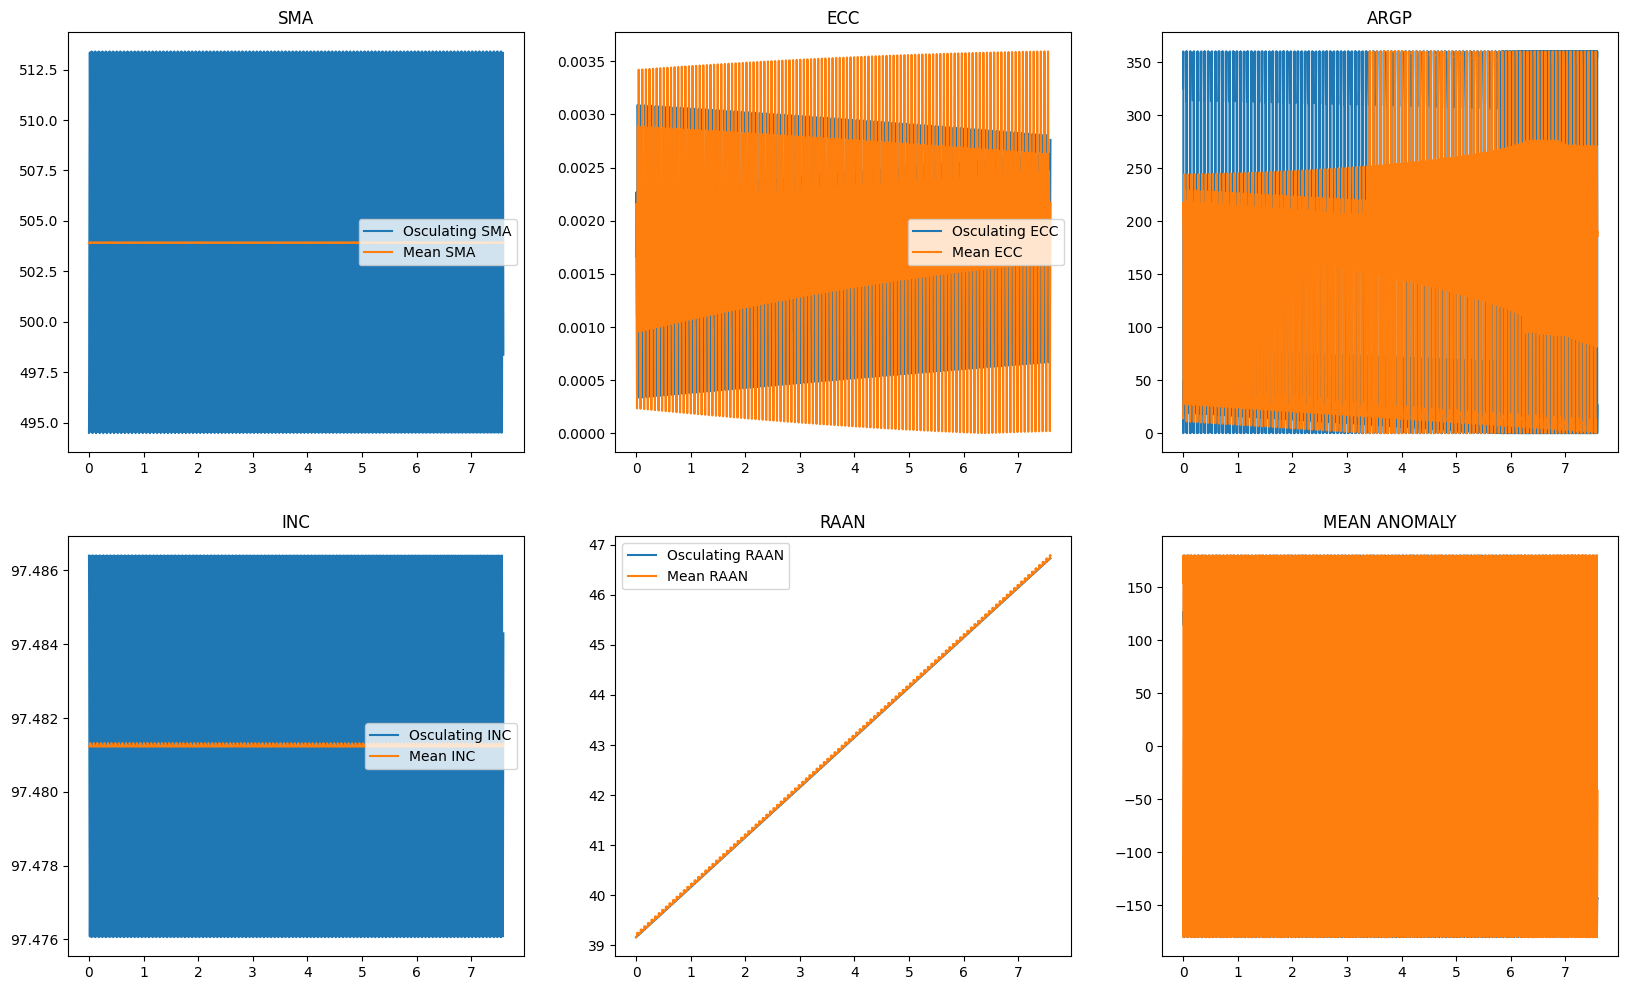

In [7]:
elapsed_days = []
for sec in range(len(elapsedsecs)-1):
    elapsed_days.append(elapsedsecs[sec]/(60*60*24))

altitudes = []
mean_altitudes = []
for sma in range(len(a_list)):
    altitudes.append(a_list[sma] - Earth.R_mean.to_value(u.km))
    mean_altitudes.append(a_mean_list[sma] - Earth.R_mean.to_value(u.km))


print(f'\nProcess finished --- {time.time() - process_start_time}')

fig, ax = plt.subplots(2,3, figsize=(20,12))
ax[0,0].plot(elapsed_days, altitudes, label='Osculating SMA')
ax[0,0].plot(elapsed_days, mean_altitudes, label='Mean SMA')
ax[0,0].legend(loc = 'center right')
ax[0,0].set_title('SMA')

ax[0,1].plot(elapsed_days, ecc_list, label='Osculating ECC')
ax[0,1].plot(elapsed_days, ecc_mean_list, label='Mean ECC')
ax[0,1].legend(loc = 'center right')
ax[0,1].set_title('ECC')

ax[1,0].plot(elapsed_days, inc_list, label='Osculating INC')
ax[1,0].plot(elapsed_days, inc_mean_list, label='Mean INC')
ax[1,0].legend(loc = 'center right')
ax[1,0].set_title('INC')

ax[1,1].plot(elapsed_days, raan_list, label='Osculating RAAN')
ax[1,1].plot(elapsed_days, raan_mean_list, label='Mean RAAN')
ax[1,1].legend(loc = 'upper left')
ax[1,1].set_title('RAAN')

ax[0,2].plot(elapsed_days, argp_list, label='Osculating ARGP')
ax[0,2].plot(elapsed_days, argp_mean_list, label='Mean ARGP')
ax[0,2].set_title('ARGP')

ax[1,2].plot(elapsed_days, nu_list, label='Osculating TA')
ax[1,2].plot(elapsed_days, ma_mean_list, label='Mean MA')
ax[1,2].set_title('MEAN ANOMALY')

plt.show()